Analysis code from PyPSA-BO

https://github.com/CIE-UMSS/PyPSA-BO/blob/main/Results_analysis/EnergyScope-PyPSA/general_analysis.ipynb

In [71]:
#Libraries import for running the code

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
import cartopy

# data exploration
import xarray as xr

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)



max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

#Load different networks

base_network= "C:/Users/hie/pe_tan/pypsa-earth/results/networks/base.nc"
n_base= pypsa.Network(base_network) #network with all components available in the data sources 

added_network = "C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec.nc"
n_add = pypsa.Network(added_network) #output from add_electricity. network with electrical parameters added to components in data sources 

simplified_network = "C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec_s.nc"
n_simple = pypsa.Network(simplified_network) #output simplyfy_network with components simplified and spatial parameters (onshore and offshore regions) added  

clustered_network = 'C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec_s_all.nc'
n_cluster = pypsa.Network(clustered_network) #output clustering-network simplified based on number of clusters give

solved_network = r'C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec_s_all_ec_lcopt_1h.nc'
n_solve = pypsa.Network(solved_network) #optimized network

n = n_solve

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers
INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_all.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [72]:
# System cost in Million Eur/Year
n
n.objective/1000000

215476.62585799338

In [73]:
#check lines

n.lines.capital_cost.sum()


298605.8947089188

In [74]:
n_simple.lines.capital_cost.sum()

372371.5032772844

In [75]:
line_expansion_cost = n.lines.s_nom_opt*432.97*n.lines.length # investment cost of transmission lines (Eur/MW) why 432.97?
print("Investment costs for line expansion: " + str(line_expansion_cost.sum()/1000000*(9.5+2.5)/2.5) + " Million Eur") 

Investment costs for line expansion: 24269.77936947013 Million Eur


In [153]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap.p_nom


carrier
CCGT       9.148374e+02
load       1.900000e+11
offwind    0.000000e+00
oil        2.662288e+02
onwind     2.066017e+00
ror        2.671260e+02
solar      1.553165e+01
Name: p_nom, dtype: float64

In [77]:
#optimized

gen_cap.p_nom_opt

carrier
CCGT          9.426675e+02
load          1.900000e+11
offwind-ac    9.493841e-04
offwind-dc    0.000000e+00
oil           2.662299e+02
onwind        2.098443e+00
ror           2.671260e+02
solar         1.728150e+03
Name: p_nom_opt, dtype: float64

In [78]:
stores_cap = n.storage_units.groupby(["carrier"]).sum()
stores_cap.p_nom_opt

carrier
hydro    2482.866242
Name: p_nom_opt, dtype: float64

In [79]:
#installed capacity expansion
generation_expansion = gen_cap['p_nom_opt'] - gen_cap['p_nom']
generation_expansion

carrier
CCGT            27.830155
load             0.000000
offwind-ac       0.000949
offwind-dc       0.000000
oil              0.001104
onwind           0.032425
ror              0.000000
solar         1712.618510
dtype: float64

In [80]:
generation_expansion.sum()

1740.4831436693207

Transmission expansion

In [81]:

n_line = pypsa.Network(base_network)
check_lines = n_line.lines
check_lines.s_nom.mean()

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


1089.727164633953

In [82]:
lines=n.lines
n.lines.s_nom.mean()

1089.727164633953

In [83]:
#transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']
transmission_expansion

Line
0      0.006361
1      0.036862
2      0.010134
3      0.004708
4      0.003284
         ...   
98     0.025577
99     0.102545
100    0.137676
101    0.048579
102    0.068434
Length: 103, dtype: float64

In [84]:
real_expansion = 0
for i in range(len(transmission_expansion)):  # Iterate over the indices of the Series
    if transmission_expansion.iloc[i] > 0:  # Check if the expansion value is greater than 0
        real_expansion += transmission_expansion.iloc[i]  # Add the expansion value to real_expansion

print("Total expansion of the system:", real_expansion)

Total expansion of the system: 19.94738395111549


In [85]:
max_line_expansion = transmission_expansion.max()
max_line_expansion

2.988695729914866

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\3926023072.py:165: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



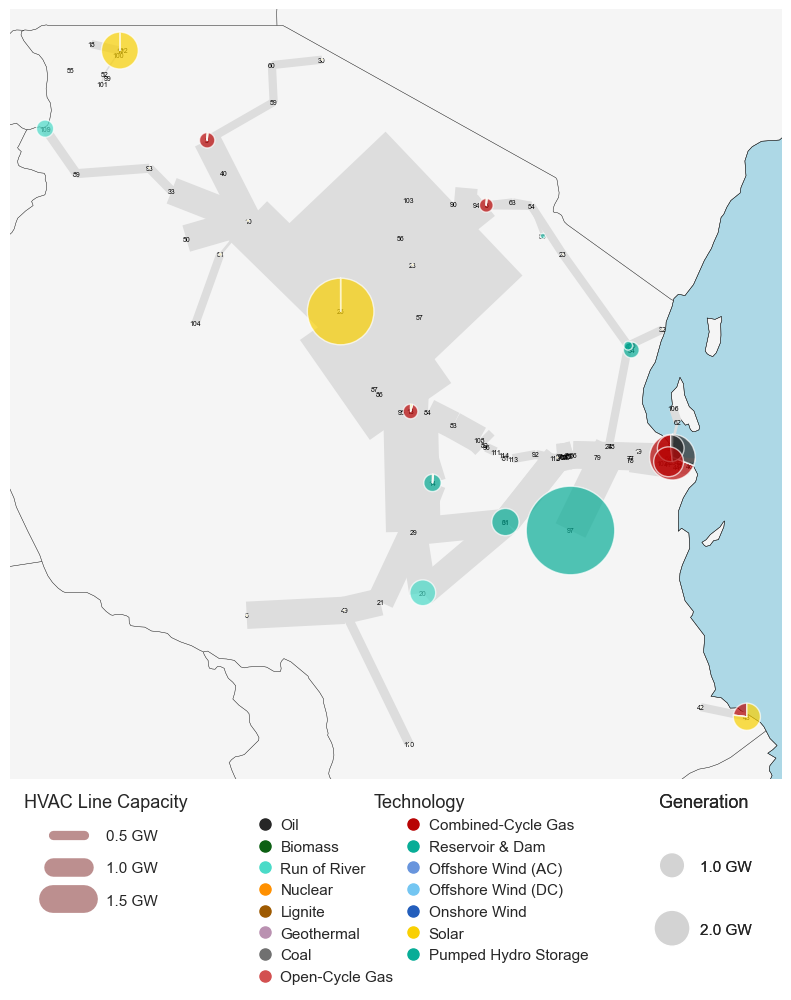

In [86]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=1.2,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    # Filter n.carriers to only exclude "H2" and "batteries"
    filtered_carriers = n.carriers.loc[~n.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )

        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 20]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.2,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 6.0e3
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=100):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
    # Add bus names to the plot
    for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
        ax.text(lon, lat, bus, fontsize=5, color='black', ha='center', va='center')


    add_legend(ax, bus_factor, branch_factor)

    


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

In [87]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Combined-Cycle Gas      9.426675e+02        9.148374e+02   
            Offshore Wind (AC)      9.493841e-04        0.000000e+00   
            Oil                     2.662299e+02        2.662288e+02   
            Onshore Wind            2.098443e+00        2.066017e+00   
            Run of River            2.671260e+02        2.671260e+02   
            Solar                   1.728150e+03        1.553165e+01   
            load                    1.900000e+11        1.900000e+11   
Line        AC                      1.122618e+05        1.122419e+05   
Link        battery charger         1.046252e+02        0.000000e+00   
            battery discharger      1.089846e+02        0.000000e+00   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         2.482866e+03        2.482866e+03   
Store       Battery Storage         9.166539e+02        0.000000e+00   

                                      Supply    Withdrawal      Dispatch  \
Generator   Combined-Cycle Gas  2.984748e+06  0.000000e+00  2.984748e+06   
            Offshore Wind (AC)  6.924885e-01  0.000000e+00  6.924885e-01   
            Oil                 4.145970e+00  0.000000e+00  4.145970e+00   
            Onshore Wind        1.946565e+03  0.000000e+00  1.946565e+03   
            Run of River        2.335153e+06  0.000000e+00  2.335153e+06   
            Solar               2.305182e+06  0.000000e+00  2.305182e+06   
            load                2.152303e+06  0.000000e+00  2.152303e+06   
Line        AC                  3.123155e+07  3.123155e+07  0.000000e+00   
Link        battery charger     2.685531e+05  2.797428e+05 -1.118971e+04   
            battery discharger  2.578123e+05  2.685545e+05 -1.074218e+04   
Load        -                   0.000000e+00  1.044053e+07 -1.044053e+07   
StorageUnit Reservoir & Dam     6.831215e+05  0.000000e+00  6.831215e+05   
Store       Battery Storage     1.985450e+05  1.985450e+05  4.669104e-06   

                                Transmission  Capacity Factor    Curtailment  \
Generator   Combined-Cycle Gas  0.000000e+00         0.361447       0.000000   
            Offshore Wind (AC)  0.000000e+00         0.083266       0.491990   
            Oil                 0.000000e+00         0.000002       0.000000   
            Onshore Wind        0.000000e+00         0.105893     144.392353   
            Run of River        0.000000e+00         0.997918       0.000000   
            Solar               0.000000e+00         0.152272  278069.827032   
            load                0.000000e+00         0.000001       0.000000   
Line        AC                 -4.348125e+06         0.031758       0.000000   
Link        battery charger     0.000000e+00         0.305224       0.000000   
            battery discharger  0.000000e+00         0.281296       0.000000   
Load        -                   0.000000e+00              NaN       0.000000   
StorageUnit Reservoir & Dam     0.000000e+00         0.031408       0.000000   
Store       Battery Storage     0.000000e+00         0.487291       0.000000   

                                Capital Expenditure  Operational Expenditure  \
Generator   Combined-Cycle Gas         9.878027e+07             1.397242e+08   
            Offshore Wind (AC)         1.957197e+02             1.749247e-02   
            Oil                        1.067225e+07             6.531309e+02   
            Onshore Wind               2.132943e+05             4.825114e+01   
            Run of River               8.232031e+07             2.189135e+04   
            Solar                      6.791021e+07             4.759404e+04   
            load                       0.000000e+00             2.152522e+11   
Line        AC                         4.917358e+08             0.000000e+00   
Link        battery charger            2.581958e+06             2.739489e+03   
            battery discharger       

In [152]:
n.statistics.dispatch().sum()

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\3758984340.py:1: DeprecatedWarning:

dispatch is deprecated as of 0.28 and will be removed in 0.29. Use 'energy_balance' instead.



0.0022609272379424117

In [88]:
# Capital expenditure for optimized values (annual values based on p_nom_opt) [Eur/year]
n.statistics.capex().sum()

766034075.5439708

In [89]:
#manual sum of components to obtain capex of the system [Million Eur/year]
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6).sum()  + (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6).sum() + (n.lines.s_nom_opt * n.lines.capital_cost).div(1e6).sum() + (n.stores.e_nom_opt * n.stores.capital_cost).div(1e6).sum()# M€/a
capex

763.452117962137

In [90]:
#manual sum of components to obatin opex of the system [Million Eur/year]
opex = (n.snapshot_weightings.generators @ n.generators_t.p * (n.generators.marginal_cost).div(1e6)).sum() + (n.snapshot_weightings.generators @ n.storage_units_t.p * (n.storage_units.marginal_cost).div(1e6)).sum()  # M€/a
opex

215391.98843808088

In [91]:
#manual sum of components to obtain capex of only the expanded capacity (p_nom_opt-p_nom) [Million Eur/year]
capex2 = ((n.generators.p_nom_opt - n.generators.p_nom)* n.generators.capital_cost).div(1e6).sum()  + ((n.storage_units.p_nom_opt - n.storage_units.p_nom ) * n.storage_units.capital_cost).div(1e6).sum() + ((n.lines.s_nom_opt - n.lines.s_nom) * n.lines.capital_cost).div(1e6).sum() + ((n.stores.e_nom_opt - n.stores.e_nom) * n.stores.capital_cost).div(1e6).sum()# M€/a
capex2

82.04999868154529

Expansion and generation charts

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\2084180376.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



<AxesSubplot:xlabel='snapshot'>

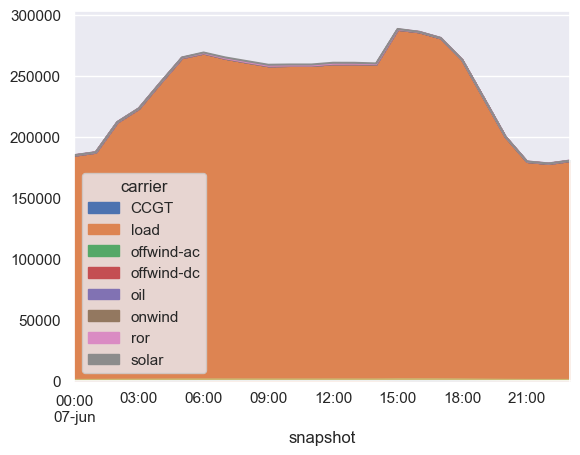

In [92]:
date1 = "2013-06-07"
date2 = "2014-01-01"
n.generators_t.p.loc[date1:date1].groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")
n.loads_t.p.loc[date1:date1].sum(axis=1).plot()

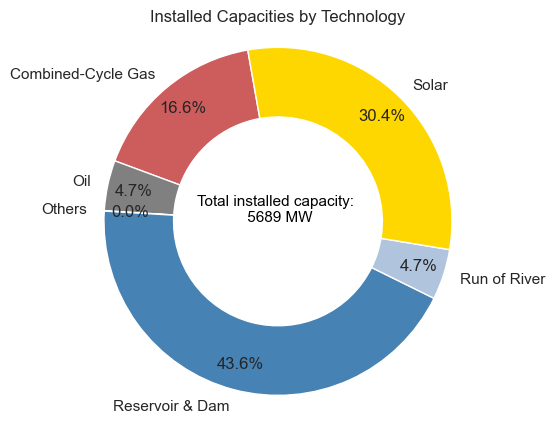

In [93]:
#selecting generation capacities from statistics
capacities = pd.DataFrame(n.statistics.optimal_capacity())
capacities = capacities.drop(index=['Line','Load','Link','Store'], level=0)
capacities = capacities.reset_index(level=0, drop=True)
capacities.rename(columns={0:"MW"}, inplace=True)
capacities.index.name = "Technology"
capacities = capacities.drop(index=['load'])
capacities['Percentage'] = capacities['MW']/capacities['MW'].sum()*100

#defining colors for each technology
H2_color='darkgoldenrod'
battery_color='tan'
demand_color='slategrey'
aggregated_small_capacities = 'black'

for i in range(len(capacities.index)):
    tech = capacities.index[i]  # Access the index value, which is the technology name
    if tech == "Open-Cycle Gas" : capacities.loc[tech, "Color"] = 'lightcoral'
    elif tech == "Combined-Cycle Gas" : capacities.loc[tech, "Color"] = 'indianred'
    elif tech == "Solar" : capacities.loc[tech, "Color"] = 'gold'
    elif tech == "Run of River" : capacities.loc[tech, "Color"] = 'lightsteelblue'
    elif tech == "Onshore Wind" : capacities.loc[tech, "Color"] = '#ff8200'
    elif tech == "Reservoir & Dam" : capacities.loc[tech, "Color"] = 'steelblue'
    elif tech == "Oil" : capacities.loc[tech, "Color"] = 'grey'
    elif tech == "Geothermal" : capacities.loc[tech, "Color"] = 'purple'
    elif tech == "Biomass" : capacities.loc[tech, "Color"] = '#73A917'

# Identify, adding and removing capacities smaller than 1%
small_capacities = capacities[capacities['Percentage'] < 2]
capacities.loc['Others'] = [small_capacities['MW'].sum(), small_capacities['Percentage'].sum(), aggregated_small_capacities]
capacities = capacities.drop(index=small_capacities.index)
capacities = capacities.sort_index()

#plotting the results

plt.figure(figsize=(5, 5))
plt.pie(capacities['MW'], labels=capacities.index, colors=capacities['Color'], autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_capacity = capacities['MW'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total installed capacity: \n {int(total_capacity)} MW', fontsize=11, color='black', ha='center')
plt.title('Installed Capacities by Technology')
plt.show()

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\3432555159.py:2: DeprecatedWarning:

dispatch is deprecated as of 0.28 and will be removed in 0.29. Use 'energy_balance' instead.



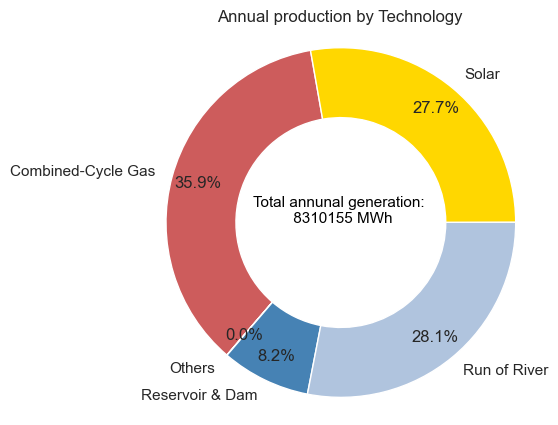

In [94]:
#selecting production from statistics
production = pd.DataFrame(n.statistics.dispatch())
production = production.drop(index=['Line','Load','Link','Store'], level=0)
production = production.reset_index(level=0, drop=True)
production.rename(columns={0:"MWh"}, inplace=True)
production.index.name = "Technology"
production = production.drop(index=['load'])
production['Percentage'] = production['MWh']/production['MWh'].sum()*100

#defining colors for each technology
H2_color='darkgoldenrod'
battery_color='tan'
demand_color='slategrey'
aggregated_small_capacities = 'black'

for i in range(len(production.index)):
    tech = production.index[i]  # Access the index value, which is the technology name
    if tech == "Open-Cycle Gas" : production.loc[tech, "Color"] = 'lightcoral'
    elif tech == "Combined-Cycle Gas" : production.loc[tech, "Color"] = 'indianred'
    elif tech == "Solar" : production.loc[tech, "Color"] = 'gold'
    elif tech == "Run of River" : production.loc[tech, "Color"] = 'lightsteelblue'
    elif tech == "Onshore Wind" : production.loc[tech, "Color"] = '#ff8200'
    elif tech == "Reservoir & Dam" : production.loc[tech, "Color"] = 'steelblue'
    elif tech == "Oil" : production.loc[tech, "Color"] = 'grey'
    elif tech == "Geothermal" : production.loc[tech, "Color"] = 'purple'
    elif tech == "Biomass" : production.loc[tech, "Color"] = '#73A917'


# Identify, adding and removing capacities smaller than 1%
small_production = production[production['Percentage'] < 1]
production.loc['Others'] = [small_production['MWh'].sum(), small_production['Percentage'].sum(), aggregated_small_capacities]
production = production.drop(index=small_production.index)
production = production.sort_index()

#plotting the results

plt.figure(figsize=(5, 5))
plt.pie(production['MWh'], labels=production.index, colors=production['Color'], autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_production = production['MWh'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total annunal generation: \n {int(total_production)} MWh', fontsize=11, color='black', ha='center')
plt.title('Annual production by Technology')
plt.show()

In [95]:
storage_capacities = pd.DataFrame(n.statistics.optimal_capacity())
storage_capacities = storage_capacities.drop(index=['Line','Generator'], level=0)
storage_capacities

0
component   carrier                        
Link        battery charger      104.625215
            battery discharger   108.984599
StorageUnit Reservoir & Dam     2482.866242
Store       Battery Storage      916.653850

In [103]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Combined-Cycle Gas      9.426675e+02        9.148374e+02   
            Offshore Wind (AC)      9.493841e-04        0.000000e+00   
            Oil                     2.662299e+02        2.662288e+02   
            Onshore Wind            2.098443e+00        2.066017e+00   
            Run of River            2.671260e+02        2.671260e+02   
            Solar                   1.728150e+03        1.553165e+01   
            load                    1.900000e+11        1.900000e+11   
Line        AC                      1.122618e+05        1.122419e+05   
Link        battery charger         1.046252e+02        0.000000e+00   
            battery discharger      1.089846e+02        0.000000e+00   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         2.482866e+03        2.482866e+03   
Store       Battery Storage         9.166539e+02        0.000000e+00   

                                      Supply    Withdrawal      Dispatch  \
Generator   Combined-Cycle Gas  2.984748e+06  0.000000e+00  2.984748e+06   
            Offshore Wind (AC)  6.924885e-01  0.000000e+00  6.924885e-01   
            Oil                 4.145970e+00  0.000000e+00  4.145970e+00   
            Onshore Wind        1.946565e+03  0.000000e+00  1.946565e+03   
            Run of River        2.335153e+06  0.000000e+00  2.335153e+06   
            Solar               2.305182e+06  0.000000e+00  2.305182e+06   
            load                2.152303e+06  0.000000e+00  2.152303e+06   
Line        AC                  3.123155e+07  3.123155e+07  0.000000e+00   
Link        battery charger     2.685531e+05  2.797428e+05 -1.118971e+04   
            battery discharger  2.578123e+05  2.685545e+05 -1.074218e+04   
Load        -                   0.000000e+00  1.044053e+07 -1.044053e+07   
StorageUnit Reservoir & Dam     6.831215e+05  0.000000e+00  6.831215e+05   
Store       Battery Storage     1.985450e+05  1.985450e+05  4.669104e-06   

                                Transmission  Capacity Factor    Curtailment  \
Generator   Combined-Cycle Gas  0.000000e+00         0.361447       0.000000   
            Offshore Wind (AC)  0.000000e+00         0.083266       0.491990   
            Oil                 0.000000e+00         0.000002       0.000000   
            Onshore Wind        0.000000e+00         0.105893     144.392353   
            Run of River        0.000000e+00         0.997918       0.000000   
            Solar               0.000000e+00         0.152272  278069.827032   
            load                0.000000e+00         0.000001       0.000000   
Line        AC                 -4.348125e+06         0.031758       0.000000   
Link        battery charger     0.000000e+00         0.305224       0.000000   
            battery discharger  0.000000e+00         0.281296       0.000000   
Load        -                   0.000000e+00              NaN       0.000000   
StorageUnit Reservoir & Dam     0.000000e+00         0.031408       0.000000   
Store       Battery Storage     0.000000e+00         0.487291       0.000000   

                                Capital Expenditure  Operational Expenditure  \
Generator   Combined-Cycle Gas         9.878027e+07             1.397242e+08   
            Offshore Wind (AC)         1.957197e+02             1.749247e-02   
            Oil                        1.067225e+07             6.531309e+02   
            Onshore Wind               2.132943e+05             4.825114e+01   
            Run of River               8.232031e+07             2.189135e+04   
            Solar                      6.791021e+07             4.759404e+04   
            load                       0.000000e+00             2.152522e+11   
Line        AC                         4.917358e+08             0.000000e+00   
Link        battery charger            2.581958e+06             2.739489e+03   
            battery discharger       

Dispatch

In [116]:
#energy generated by type of powerplant
production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()
production_cap.sum()

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\2440099205.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



carrier
CCGT          2.984748e+06
load          2.152303e+09
offwind-ac    6.924885e-01
offwind-dc    0.000000e+00
oil           4.145970e+00
onwind        1.946565e+03
ror           2.335153e+06
solar         2.305182e+06
dtype: float64

In [ ]:
#installed capacity p_nom= nominal power (MW) and p_nom_opt= optimized nominal power (MW)

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])

                   p_nom     p_nom_opt
carrier                               
CCGT        9.148374e+02  9.426675e+02
load        1.900000e+11  1.900000e+11
offwind-ac  0.000000e+00  9.493841e-04
offwind-dc  0.000000e+00  0.000000e+00
oil         2.662288e+02  2.662299e+02
onwind      2.066017e+00  2.098443e+00
ror         2.671260e+02  2.671260e+02
solar       1.553165e+01  1.728150e+03

hydro storage : p_nom: 2482.8662420382166  p_nom_opt: 2482.8662420382166
                    p_nom   p_nom_opt
carrier                              
battery charger       0.0  104.625215
battery discharger    0.0  108.984599


C:\Users\hie\AppData\Local\Temp\ipykernel_26548\538976059.py:13: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\538976059.py:19: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\538976059.py:28: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\538976059.py:34: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\538976059.py:35: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\538976059.py:36: FutureWarning:

DataFrame.groupby with axis=1 is deprecated.

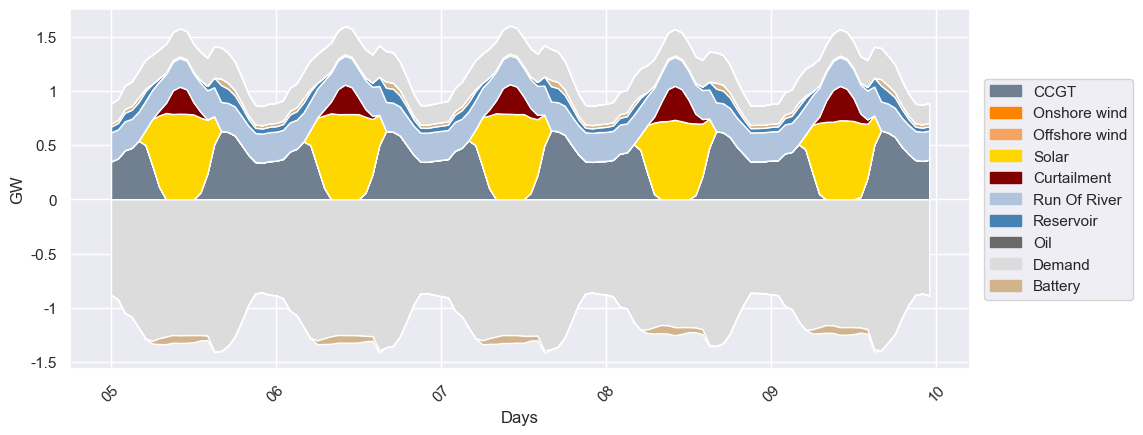

                p_nom     p_nom_opt
carrier                            
CCGT     9.148374e+02  9.426675e+02
load     1.900000e+11  1.900000e+11
offwind  0.000000e+00  9.493841e-04
oil      2.662288e+02  2.662299e+02
onwind   2.066017e+00  2.098443e+00
ror      2.671260e+02  2.671260e+02
solar    1.553165e+01  1.728150e+03

hydro storage : p_nom: 2482.8662420382166  p_nom_opt: 2482.8662420382166
                    p_nom   p_nom_opt
carrier                              
battery charger       0.0  104.625215
battery discharger    0.0  108.984599


In [142]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

first_date = "2013-06-05"
second_date = "2013-06-09"

#Hourly solar curtailment calculation
maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation

#Hourly wind curtailment calculation
maximum_wind_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='onwind') * n.generators.loc[[idx for idx in n.generators.index if 'onwind' in idx]]['p_nom_opt']
maximum_wind_generation = maximum_wind_generation.sum(axis=1)
wind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
curtailment_wind = maximum_wind_generation- wind_generation


# Combine 'offwind-ac' and 'offwind-dc' into a single 'offwind' carrier
n.generators["carrier"] = n.generators["carrier"].replace({"offwind-ac": "offwind", "offwind-dc": "offwind"})

maximum_offwind_genertation=n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='offwind') * n.generators.loc[[idx for idx in n.generators.index if 'offwind' in idx]]['p_nom_opt']
maximum_offwind_genertation = maximum_offwind_genertation.sum(axis=1)
offwind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["offwind"]
curtailment_offwind = maximum_offwind_genertation - offwind_generation

curtailment = curtailment_solar.loc[first_date:second_date] + curtailment_wind.loc[first_date:second_date]+offwind_generation.loc[first_date:second_date]

#Hourly generation per technology
CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
offwind=n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["offwind"]

#LoadShedding
load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]

#Hourly load/demand 
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

size = CCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
else:
    biomass = None

if "OCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
else:
    OCGT = None
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "load" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]/1000
else:
    load = np.zeros(size)

    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    


#Hourly storage charge or discharge 
i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 



# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])


CCGT_color='slategrey'
Onwind_color='#ff8200'
Offwind_color='sandybrown'
Solar_color='gold'
curtailment_color = 'maroon'
ror_color='lightsteelblue'
reservoir_color='steelblue'
battery_color='tan'
oil_color='dimgrey'
biomass_color='#73A917'
demand_color='gainsboro'
lostload_color = "maroon"

# Prepare data for stackplot
stack_data = [CCGT, Onwind, solar, curtailment, ror, reservoir, pbattery, oil, load, offwind]
stack_colors = [CCGT_color, Onwind_color, Solar_color, curtailment_color, ror_color, reservoir_color, battery_color, oil_color, demand_color, Offwind_color]

if biomass is not None:
    stack_data.append(biomass)
    stack_colors.append(biomass_color)

if OCGT is not None:
    stack_data.append(OCGT)
    stack_colors.append('lightcoral')

# Create the stackplot
plt.stackplot(CCGT.index, *stack_data, colors=stack_colors, zorder=3)


plt.stackplot(CCGT.index,demand,nbattery, colors=[demand_color,battery_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Days')


CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
curtailment_patch = mpatches.Patch(color=curtailment_color, label = 'Curtailment')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')
offwind_patch = mpatches.Patch(color=Offwind_color, label ='Offshore wind')
battery_patch = mpatches.Patch(color=battery_color, label ='Battery')
oil_patch = mpatches.Patch(color=oil_color, label ='Oil')
biomass_patch = mpatches.Patch(color=biomass_color, label ='Biomass')
load_patch = mpatches.Patch(color=demand_color, label ='Demand')

lostload_patch = mpatches.Patch(color=demand_color, label ='LostLoad')

handles = [
    CCGT_patch, wind_patch, offwind_patch, solar_patch, curtailment_patch,
    ror_patch, reservoir_patch, oil_patch, load_patch, battery_patch
]

if biomass is not None:
    handles.append(biomass_patch)

if OCGT is not None:
    handles.append(mpatches.Patch(color='lightcoral', label='OCGT'))    

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = '.png' 


plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])


In [150]:
# List of generator carriers
generator_list = ["CCGT", "OCGT", "oil", "biomass", "geothermal", "onwind", "solar", "ror","offwind"]

# Loop through each carrier in the generator list
for carrier in generator_list:
    # Filter generators by carrier and sum their generation
    if carrier in n.generators.carrier.unique():
        generation = n.generators_t.p.loc[:, n.generators[n.generators.carrier == carrier].index].sum().sum()
        print(f"{carrier} generation (MWh) = {round(generation)}")
    else:
        print(f"{carrier} generation (MWh) = 0 (not present in the network)")

# List of storage unit carriers
generator_list2 = ["hydro"]

# Loop through each carrier in the storage unit list
for carrier in generator_list2:
    # Filter storage units by carrier and sum their generation
    if carrier in n.storage_units.carrier.unique():
        generation = n.storage_units_t.p.loc[:, n.storage_units[n.storage_units.carrier == carrier].index].sum().sum()
        print(f"{carrier} generation (MWh) = {round(generation)}")
    else:
        print(f"{carrier} generation (MWh) = 0 (not present in the network)")

CCGT generation (MWh) = 2984748
OCGT generation (MWh) = 0 (not present in the network)
oil generation (MWh) = 4
biomass generation (MWh) = 0 (not present in the network)
geothermal generation (MWh) = 0 (not present in the network)
onwind generation (MWh) = 1947
solar generation (MWh) = 2305182
ror generation (MWh) = 2335153
offwind generation (MWh) = 1
hydro generation (MWh) = 683122


Lost load

In [156]:
demand = n.loads_t.p_set.loc["2013"].sum(axis=1)
demand.idxmax()
demand.sum()

10440526.558063824

In [118]:
load_shedding = n.generators_t.p.loc["2013"].groupby(n.generators.carrier, axis=1).sum()["load"]
round(load_shedding.sum())

C:\Users\hie\AppData\Local\Temp\ipykernel_26548\1555212878.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



2152303254

In [119]:
#LL or Loadshedding is in kW/kWh 
lostload = n.generators_t.p.filter(like= "load")
#lostload.idxmax()
peakLL = pd.DataFrame(index = lostload.index)
peakLL["Peak LL"] = lostload.max(axis=1)/1000
sortedLL = peakLL.sort_values("Peak LL", ascending=False)
LL_contribution = sortedLL.iloc[0:9]
LL_contribution.mean()

Peak LL    122.895463
dtype: float64